<a href="https://colab.research.google.com/github/pepperamy/tenK_phase2/blob/main/Copy_of_10k_featureselection_cnnlstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
import pandas as pd
import pickle
import re
from matplotlib import pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from scipy.optimize import linear_sum_assignment
import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import mstats
import math

from sklearn.model_selection import train_test_split

In [130]:
from sklearn.model_selection import KFold,StratifiedKFold

In [131]:
from keras import regularizers

In [14]:
from keras import backend as K

In [15]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, precision_recall_curve, classification_report,accuracy_score, auc, roc_curve, roc_auc_score, average_precision_score

In [16]:
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from keras.layers import Embedding, Dense, Conv2D, MaxPooling2D, Reshape, Conv1D, MaxPooling1D,\
Dropout, Activation, Input, Flatten, Concatenate, BatchNormalization, Lambda, LSTM, GRU, Bidirectional
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.models import Model
from keras import optimizers
from keras import metrics
from keras import models
from keras import layers

In [17]:
from sklearn.utils import class_weight

In [18]:
from sklearn import utils

In [19]:
import random

In [20]:
df = pd.read_csv('data_performance_words_win1_comb_20210301.csv')

In [21]:
df.shape

(53635, 212)

In [22]:
sum(df.label)

487.0

In [23]:
df.head()

,cik,y1,y2,s1,window,label,sic_class_x,rsst_acc,ch_rec,ch_inv,soft_asset,ch_cs,ch_roa,issue,aqi,asset_turnover,cfed,depi,gmi,ig,opm,rg,sg,sgee,pastavg5,pastavg3,pastavg1,cr5,cr3,cr1,WeakModal_3_avg,WeakModal_3_dis,WeakModal_3_n,WeakModal_3_new,WeakModal_3_p,WeakModal_3_u,Litigious_3_avg,Litigious_3_dis,Litigious_3_n,Litigious_3_new,...,Achieve_3_p,Achieve_3_u,Power_3_avg,Power_3_dis,Power_3_n,Power_3_new,Power_3_p,Power_3_u,Reward_3_avg,Reward_3_dis,Reward_3_n,Reward_3_new,Reward_3_p,Reward_3_u,Risk_3_avg,Risk_3_dis,Risk_3_n,Risk_3_new,Risk_3_p,Risk_3_u,WeakModal_up,WeakModal_down,Litigious_up,Litigious_down,StrongModal_up,StrongModal_down,Negative_up,Negative_down,Positive_up,Positive_down,Uncertainty_up,Uncertainty_down,Compare_up,Compare_down,Achieve_up,Achieve_down,Discrep_up,Discrep_down,Reward_up,Reward_down
0,20.0,1995.0,1996.0,0.633505,1.0,0.0,3,0.063117,-0.072425,-0.067847,0.661974,-0.147079,0.198730,1,0.974056,1.624273,0.206066,1.226305,0.914198,0.715334,0.044798,0.783539,0.814093,1.013528,NaN,NaN,NaN,NaN,NaN,NaN,-0.000071,0.000000,0.095238,0.004950,0.047619,0.761905,-0.002775,0.002801,0.190476,0.000000,...,0.047619,0.571429,-0.004527,0.016180,0.428571,0.029638,0.285714,0.190476,-0.000009,0.002644,0.190476,0.000000,0.190476,0.523810,-0.002433,0.002488,0.333333,0.019737,0.000000,0.571429,0.052570,0.095238,0.142857,0.193277,0.047619,0.058512,0.353070,0.338308,0.238095,0.292404,0.100189,0.145658,0.395804,0.355975,0.060777,0.303224,0.190476,0.248916,0.190476,0.193121
1,20.0,1996.0,1997.0,0.803827,1.0,0.0,3,0.066126,-0.018252,-0.059281,0.620435,-0.066028,0.034753,1,1.248039,1.606518,0.025826,1.088859,0.978102,0.755016,0.062466,0.938786,0.969746,1.012432,0.633505,0.633505,0.633505,1.268856,1.268856,1.268856,-0.000034,0.000000,0.066667,0.028571,0.000000,0.866667,0.003234,0.000000,0.133333,0.000000,...,0.133333,0.733333,-0.003780,0.018289,0.333333,0.000000,0.200000,0.400000,0.000668,0.007947,0.200000,0.000000,0.200000,0.533333,-0.001054,0.013954,0.066667,0.000000,0.066667,0.800000,0.028571,0.066667,0.200000,0.133333,0.161905,0.066667,0.161905,0.357243,0.200000,0.219242,0.123810,0.134598,0.333333,0.144428,0.133333,0.075494,0.133333,0.070482,0.200000,0.207947
2,20.0,1997.0,1998.0,0.462705,1.0,0.0,3,0.095900,0.066711,0.013223,0.656729,-0.030720,0.019574,1,0.840540,1.574474,0.020191,0.991780,0.991078,1.073227,0.073961,1.241132,1.022834,0.983269,0.718666,0.718666,0.803827,0.643838,0.643838,0.575627,0.002823,0.005714,0.066667,0.007841,0.133333,0.466667,-0.001499,0.004000,0.133333,0.004315,...,0.066667,0.333333,0.000062,0.028035,0.266667,0.021889,0.266667,0.133333,-0.003310,0.001504,0.266667,0.002960,0.000000,0.400000,-0.000069,0.011111,0.066667,0.004688,0.066667,0.533333,0.141174,0.072381,0.137649,0.137333,0.074024,0.139048,0.149893,0.299598,0.070786,0.271178,0.154181,0.144762,0.484144,0.236060,0.074921,0.277778,0.076624,0.202532,0.002960,0.268170
3,20.0,1998.0,1999.0,0.701689,1.0,0.0,3,0.054997,0.026323,-0.009875,0.676757,0.011434,0.002424,1,0.837833,1.604656,0.003715,1.025961,1.024634,0.948804,0.076906,1.077020,0.985921,0.983057,0.633346,0.633346,0.462705,1.107909,1.107909,1.516495,0.000590,0.006755,0.045455,0.000000,0.136364,0.545455,-0.000112,0.005460,0.090909,0.000000,...,0.090909,0.590909,0.001965,0.034894,0.090909,0.019415,0.136364,0.500000,0.000347,0.003575,0.000000,0.008179,0.045455,0.681818,-0.000126,0.003620,0.090909,0.000000,0.090909,0.545455,0.136364,0.052210,0.045455,0.096370,0.048976,0.140434,0.093257,0.110468,0.045455,0.050488,0.187374,0.063963,0.195518,0.159758,0.101197,0.055574,0.103194,0.144520,0.053633,0.003575
4,20.0,1999.0,2000.0,0.823023,1.0,0.0,3,-0.024892,-0.024929,0.041267,0.705573,-0.001713,-0.014429,1,1.093648,1.560280,-0.015406,0.942174,0.995699,1.221034,0.068754,0.933610,0.966150,1.000184,0.650432,0.656074,0.701689,1.265350,1.254468,1.172917,-0.000791,0.002083,0.176471,0.000000,0.000000,0.764706,-0.000278,0.003717,0.117647,0.000000,...,0.176471,0.647059,-0.001826,0.011784,0.117647,0.054348,0.058824,0.

In [24]:
df_fl = df[(df.y2 <= 2012) & (df.y2 >= 1995 ) ]

In [25]:
df_fl.label.value_counts()

0.0    53148
1.0      487
Name: label, dtype: int64

In [26]:
df_fl.shape

(53635, 212)

In [27]:
selected_new = ['WeakModal', 'Litigious', 'StrongModal','Negative', 'Positive', 'Uncertainty', 
        'Compare', 'Achieve', 'Discrep', 'Reward']

v_perf = ['aqi',
 'asset_turnover',
 'depi',
 'gmi',
 #'ig',
 'opm',
 'rg',
 'sg',
 'sgee',
 'ch_rec',
 'ch_inv',
 'soft_asset',
 'ch_cs',
 'ch_roa',
 'issue']

v_1 = ['s1']
v_2 = ['pastavg3','cr3']

In [28]:
selected_comb = []
for s in selected_new:
  selected_comb.append(s+'_up')
  selected_comb.append(s+'_down')

In [29]:
selected_new_all = []
temp = []
for s in selected_new:
    wrd = s.split('_')[0]
    if wrd not in temp:
        #print(s,'\n',temp)
        #selected_new_all.append(wrd+'_3_avg')
        selected_new_all.append(wrd+'_3_p')
        selected_new_all.append(wrd+'_3_n')
        #selected_new_all.append(wrd+'_3_u')
        selected_new_all.append(wrd+'_3_new')
        selected_new_all.append(wrd+'_3_dis')
        temp.append(wrd)
    else: 
        pass

In [ ]:
selected_new_all

In [91]:
selected_new_all_sorted = []
selected_new_all_p = []
selected_new_all_n = []
selected_new_all_new = []
selected_new_all_dis = []
for s in selected_new_all:
  if 'new' in s.split('_'):
    selected_new_all_new.append(s)
  elif 'p' in s.split('_'):
    selected_new_all_p.append(s)
  elif 'n' in s.split('_'):
    selected_new_all_n.append(s)
  elif 'dis' in s.split('_'):
    selected_new_all_dis.append(s)

for i, w in enumerate(selected_new_all_p):
  selected_new_all_sorted.append(selected_new_all_p[i])
  selected_new_all_sorted.append(selected_new_all_new[i])
  selected_new_all_sorted.append(selected_new_all_n[i])
  selected_new_all_sorted.append(selected_new_all_dis[i])  


In [ ]:
selected_new_all_sorted

In [ ]:
# def model_cnn(w, num_wrds, num_depth):
#   model = None
#   input_wds = Input(shape=(w, num_wrds, 1),dtype='float32', name='input_words')

#   cov = Conv2D(4, (2,2), activation='relu')(input_wds)
#   maxpool = MaxPooling2D((1,1))(cov)
#   #reshp = Reshape((1,64))(maxpool)
#   #flt = Flatten()(maxpool)
#   model = Model(inputs=input_wds, outputs= maxpool)
#   model._name = 'cnn'          
#   model.summary()
#   return model



In [ ]:
# def model_lstm(n1, n2, n3, w, num_wrds, num_perf, num_depth):
#     model = None
    
#     input_perf = Input(shape=(1,num_perf),dtype='float32', name='input_financial')
#     input_wds = Input(shape=(w,num_wrds),dtype='float32', name='input_words')

#     cnnmodel = model_cnn(w, num_wrds, num_depth)
#     cnn_wrds = cnnmodel(input_wds)

#     reshp_perf = Reshape((1,num_perf))(input_perf)

#     concate = Concatenate(axis=-1)([cnn_wrds,input_perf])

#     #nor = BatchNormalization()(concate)
#     drop1 = Dropout(0.3)(concate)
#     #nor = BatchNormalization()(drop1)
#     # LSTM_w_1 = Bidirectional(LSTM(81,recurrent_dropout = 0.2, name = 'layer_lstm_1',\
#     #                   return_sequences=True, \
#     #                #kernel_regularizer=regularizers.l2(0.01),\
#     #                #bias_regularizer=regularizers.l2(0.01),
#     #               activity_regularizer=regularizers.l2(0.01)))(drop1)
#     LSTM_w_2 = LSTM(81,recurrent_dropout = 0.2, name = 'layer_lstm_2', \
#                 return_sequences=False )(drop1)        
#     #nor = BatchNormalization()(LSTM_w_2)
#     dense1 = Dense(81, activation='relu', name='dense1')(LSTM_w_2)
#     dense2 = Dense(n3, activation='relu', name='dense2')(dense1)
#     nor = BatchNormalization()(dense2)
#     drop2 = Dropout(0.3)(nor)
    
#     preds = Dense(1, activation='sigmoid', name='output')(drop2)
#     model = Model(inputs=[input_perf, input_wds], outputs=preds)
#     model._name = "lstm"
#     model.summary()
    
#     return model

In [104]:
#LR
# def model_cnn_lstm(n1, n2, n3, T, perf, words, channel, filters = 24):
#     model = None
    
#     input_perf = Input(shape=(T,perf), \
#                       dtype='float32', name='input_perf')
    
#     input_words = Input(shape=(T, words, channel), \
#                       dtype='float32', name='input_words') 
    
#     word_norm = BatchNormalization()(input_words)
    
    
#     conv = Conv2D(filters = filters,\
#                   kernel_size = 1,\
#                   use_bias = False,\
#                   activation = None)(word_norm)  # Shape None x T x words x filters
#     print("conv shape:", K.int_shape(conv))
#     conv = BatchNormalization()(conv)
#     conv = Activation("relu") (conv)
    
#     pool = MaxPooling2D(pool_size=(1, words), \
#                         strides=(1,1))(conv) # None x T x filters
#     pool = Reshape((T, filters))(conv)
#     print("pool shape:", K.int_shape(pool))
    
#     #drop = Dropout(0.3)(input_all)
#     # Now concatenate
#     perf_norm = BatchNormalization()(input_perf)
#     all_input = Concatenate(axis = -1)([perf_norm, pool])
#     #nor = BatchNormalization()(all_input)
    
#     LSTM_w_1 = Bidirectional(LSTM(n1, dropout= 0.3, recurrent_dropout = 0.3,\
#                     name = 'layer_lstm_1', return_sequences=True))(all_input)
#     LSTM_w_2 = LSTM(n2, dropout= 0.3, recurrent_dropout = 0.3,
#                    name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)
    
#     dense = Dense(n3, activation='relu', name='dense')(LSTM_w_2)
#     drop = Dropout(0.3)(dense)
    
#     preds = Dense(1, activation='sigmoid', name='output')(drop)
#     model = Model(inputs=[input_perf, input_words], outputs=preds)
#     model._name = "model_cnnlstm"
#     model.summary()
    
#     return model

In [172]:
def model_cnn_lstm(n1,n2,n3,T, perf, words, types ,filters = 64): #channel,
    model = None
    filters = 32
    
    input_perf = Input(shape=(T,perf), \
                      dtype='float32', name='input_perf')
    
    input_words = Input(shape=(T,words,types), \
                      dtype='float32', name='input_words')
    #1D:
    # conv = Conv1D(filters = filters,\
    #               kernel_size = 1,\
    #               activation = 'relu')(input_words)  # Shape None x T x words x filters
    # print("conv shape:", K.int_shape(conv))
    
    # pool = MaxPooling1D(pool_size= 1, \
    #                     strides=1)(conv) # None x T x filters
    
    #2D:
    #filters = 10
    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(input_words)  # Shape None x T x words x filters
    print("conv shape 1:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)


    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(conv)  # Shape None x T x words x filters
    print("conv shape 2:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)


    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(conv)  # Shape None x T x words x filters
    print("conv shape 3:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)

    
    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(conv)  # Shape None x T x words x filters
    print("conv shape 4:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    
    pool = MaxPooling2D(pool_size= (1,8), \
                        strides=1)(conv) # None x T x filters
    
    print("pool_init shape:", K.int_shape(pool))
    pool = Reshape((T, 32))(pool)
    print("pool shape:", K.int_shape(pool))
    
    #drop = Dropout(0.3)(input_all)
    # Now concatenate
    perf_norm = BatchNormalization()(input_perf)
    all_input = Concatenate(axis = -1)([perf_norm, pool])
    nor = BatchNormalization()(all_input)
    
    LSTM_w_1 =Bidirectional(LSTM(n1,  recurrent_dropout = 0.2,
                    name = 'layer_lstm_1', return_sequences=True,
                    kernel_regularizer = regularizers.l2(0.01),
                    activity_regularizer = regularizers.l2(0.01),
                    bias_regularizer = regularizers.l2(0.01)
                    ))(nor)
    LSTM_w_2 = LSTM(n2, recurrent_dropout = 0.2, 
                   name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)

    dense = Dense(32, activation='relu', name='dense')(LSTM_w_2)
    nor = BatchNormalization()(dense)
    drop = Dropout(0.3)(nor)
    preds = Dense(1, activation='sigmoid', name='output')(drop)
    model = Model(inputs=[input_perf, input_words], outputs=preds)
    model._name = "model_cnnlstm"
    model.summary()
    
    return model

In [35]:
def performance_measure(pred_yp, y):
    '''
    Given lists of predicted y probability and x, y, return a dataframe of AR, AUC, Brier, Decile Table
    '''
    
    tenc_dat = pd.DataFrame({'y_true':y,'probability':pred_yp.flatten()})
    tenc_dat.sort_values('probability',axis = 0,ascending=False, inplace = True)
    tenc_dat.index = range(0,len(tenc_dat))
    y = tenc_dat['y_true']
    point = float(len(tenc_dat))/10
    point = int(round(point))
    tenc = []
    for i in range(0,10):
        tenc.append(y[(i*point):((i+1)*point)])
    tenc[9]=tenc[9].append(y[10*point:])
    total = sum(y)
    num_of_bkr = []
    for j in range(0,10):
        num_of_bkr.append(sum(tenc[j]))
    tencile_bkr = np.array(num_of_bkr)
    rate = tencile_bkr.astype(float)/total

    return rate

In [106]:
class AUCEvaluation(Callback):
    """ Show AUC after interval number of epoches """
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            logs['auc'] = score
            tencile=performance_measure(y_pred, self.y_val)
            logs['tencile'] = tencile
            print(" epoch:{:d} auc: {:.4f}".format(epoch, score))


In [127]:
def fit_model( model,x_train, y_train, x_val, y_val, x_test, y_test, model_name, verbose = 0):
    
    history = None
    result = None
    
    model_df = model
    print('in fit', y_test.shape, sum(y_test))
    #class weight
    class_weights = class_weight.compute_class_weight('balanced',
                              np.unique(y_train),
                              y_train)
    class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}
    # class weight for val
    val_class_weights = class_weight.compute_class_weight('balanced',
                                np.unique(y_test),
                                y_test)
    val_class_weights = {l:c for l,c in zip(np.unique(y_test), val_class_weights)}
    val_sample_weights = []
    for y in y_test:
        if y == 1:
          val_sample_weights.append(val_class_weights[1])
        else: val_sample_weights.append(val_class_weights[0])
    val_sample_weights = np.asarray(val_sample_weights)
    print('in fit val weights', val_sample_weights.shape)
    
    auc_eval = AUCEvaluation(validation_data=(x_val, y_val), interval=1)
    earlyStopping = EarlyStopping(monitor='val_loss',patience = 3, verbose =verbose, mode ='min')
    checkpoint = ModelCheckpoint(model_name,monitor='val_my_auc',verbose=verbose,save_best_only=True, save_weights_only=True, mode ='max')

    opt = optimizers.RMSprop(lr=0.0005)
    model_df.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.AUC(name='my_auc')])

    history = model_df.fit(x_train,
                y_train,
                epochs=15,
                batch_size=128,
                verbose =verbose,
                #callbacks=[auc_eval],\
                callbacks=[auc_eval, earlyStopping, checkpoint], #checkpoint
                class_weight = class_weights, \
                validation_data=(x_val, y_val, val_sample_weights)) 
    
    model_df.load_weights(model_name)
    y_pred = model_df.predict(x_test)
    y_pred_1=np.reshape(y_pred, -1)
    auc_score = roc_auc_score(y_test, y_pred_1)
    #auc_score = roc_auc_score(y_test, y_pred_1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_1)
    print("AUC: " ,round(auc_score,4))
        
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

        
    return history, auc_score, fpr, tpr, thresholds, [y_test, y_pred_1]

In [108]:
def cross_val(data, label, perf_cols, words_cols, name, w, filters = 24):
    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    predicted_res =[]
    
    kf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
    c = 0

    X_perf, X_word, Y = shift_data(df_fl, 2, \
                    perf_cols, \
                    words_cols, \
                    'label')
    
    for train_index, test_index in kf.split(range(len(X_perf)),Y):
        
        c += 1
        
        l1 = X_perf.shape[-1]+ filters + 16
        
        model = model_cnn_lstm(l1,l1,32,\
                    X_perf.shape[1],\
                    X_perf.shape[2],
                    X_word.shape[2], \
                    X_word.shape[3], \
                    filters = 24)
    
        #model = model_lstm(n1,n2,n,w)
        train_perf_data = X_perf[train_index]
        train_word_data = X_word[train_index]
        train_label = Y[train_index]
        test_perf_x = X_perf[test_index]
        test_word_x = X_word[test_index]
        test_y = Y[test_index] 
        
        train_data = [train_perf_data, train_word_data]
        test_x = [test_perf_x, test_word_x]

        mod_res = fit_model(model, train_data, train_label, test_x, test_y, test_x, test_y,\
                  name+'_'+str(c)+'_lstm_model')
        history = mod_res[0]
        
        
        
        auc_list.append(mod_res[1])
        tprs.append(np.interp(mean_fpr, mod_res[2], mod_res[3]))
        temp_pred_res = [mod_res[-1],test_index]
        print(len(test_index))
        predicted_res.append(temp_pred_res)
        
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    
    return np.average(auc_list),mean_tpr,predicted_res

In [72]:
a = np.arange(16).reshape((2,8))

In [73]:
a

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15]])

In [5]:
a.reshape((2,8), order = '')

array([[ 0,  8,  1,  9,  2, 10,  3, 11],
       [ 4, 12,  5, 13,  6, 14,  7, 15]])

In [7]:
a.reshape((2,4,2), order = 'C')

array([[[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7]],

       [[ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15]]])

In [128]:
def shift_data(data, step, perf_cols, words_cols, label):
    A = []
    
    cols = perf_cols + words_cols
    A.append(data[cols].values)
    
    for t in range(1, step):
        d = data.groupby("cik")[cols].shift(1)
        A.append(d.values)
    A = A[::-1]
    A = np.concatenate(A, axis = 1)  # flatten shifted columns
    A = np.concatenate([data[label].values[:,None], A], axis = 1)  # add target
    #np.random.shuffle(A)
    #print(A[3])
    print(A.shape)
    # print(A[3,:])
    # print(data[cols].iloc[4,:])


    
    A = A[~np.isnan(A).any(axis=1)]  # drop nan
    

    Y = A[:,0]  # get target
    #A = np.reshape(A[:,1:], (len(A), step, len(cols))) # reshape

    A = np.reshape(A[:,1:], (len(A), step, len(perf_cols) + len(words_cols)))
    
    A_perf = A[:, :, 0:len(perf_cols)]
    # CNN_LSTM must be None x T x words x 4
    A_words = A[:, :, len(perf_cols):]
    #convert the shape to [[_p,_new][_dis,_n]]
    A_words = A_words.reshape((len(A), step, int(len(words_cols)/2), 2), order = 'C')
    
    print(A_perf.shape, A_words.shape, Y.sum())
    return A_perf, A_words, Y


In [102]:
#shift_perf,shit_wrd, _y = shift_data(df_fl, 2, v_perf + v_1+ v_2, selected_new_all_sorted, label='label')

In [103]:
#shit_wrd[4]


 ======= Select columns for LSTM ALL OBS.=========
(53635, 111)
(45945, 2, 15) (45945, 2, 20, 2) 408.0
conv shape 1: (None, 2, 17, 32)
conv shape 2: (None, 2, 14, 32)
conv shape 3: (None, 2, 11, 32)
conv shape 4: (None, 2, 8, 32)
pool_init shape: (None, 2, 1, 32)
pool shape: (None, 2, 32)
Model: "model_cnnlstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
conv2d_184 (Conv2D)             (None, 2, 17, 32)    288         input_words[0][0]                
__________________________________________________________________________________________________
batch_normalization_300 (BatchN (None, 2, 17, 32)    128         conv2d_184[0][0]           

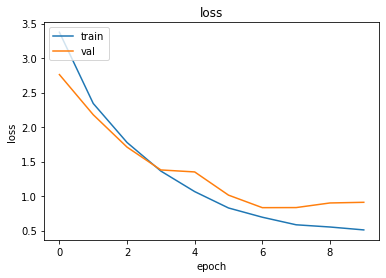

15315
conv shape 1: (None, 2, 17, 32)
conv shape 2: (None, 2, 14, 32)
conv shape 3: (None, 2, 11, 32)
conv shape 4: (None, 2, 8, 32)
pool_init shape: (None, 2, 1, 32)
pool shape: (None, 2, 32)
Model: "model_cnnlstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 2, 17, 32)    288         input_words[0][0]                
__________________________________________________________________________________________________
batch_normalization_307 (BatchN (None, 2, 17, 32)    128         conv2d_188[0][0]                 
___________________________________________________________________________________________

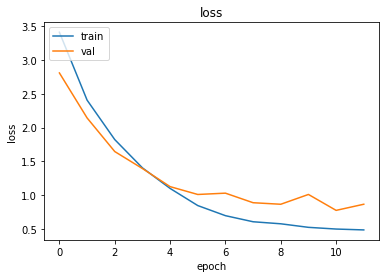

15315
conv shape 1: (None, 2, 17, 32)
conv shape 2: (None, 2, 14, 32)
conv shape 3: (None, 2, 11, 32)
conv shape 4: (None, 2, 8, 32)
pool_init shape: (None, 2, 1, 32)
pool shape: (None, 2, 32)
Model: "model_cnnlstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
conv2d_192 (Conv2D)             (None, 2, 17, 32)    288         input_words[0][0]                
__________________________________________________________________________________________________
batch_normalization_314 (BatchN (None, 2, 17, 32)    128         conv2d_192[0][0]                 
___________________________________________________________________________________________

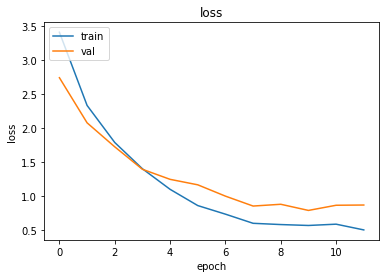

15315
avg_AUC :  0.7533907462451349
avg_AUC_2 :  0.7531689443454149


In [173]:
#@title Default title text
print("\n ======= Select columns for LSTM ALL OBS.=========")

result = []

# First choose all varaibles
#cols = v_perf + v_1+ v_2 + selected_new_all #must order like this
w = 2
perf_cols = v_perf + v_1
words_cols = selected_new_all_sorted
#num_depth = 4
label = 'label'
h = cross_val( df_fl, 'label', \
          perf_cols,\
          words_cols, \
          'cnn_lstm',w, \
          filters = 64)
    
best_auc = h[0]

# Next, remove one from the list each time



In [ ]:
#best_auc

0.752735165519567

In [ ]:

#all_cols = selected_new_all

# selected_cols = selected_new_all + v_1 + v_2
# random.shuffle(selected_cols)

# for col in selected_cols:
    
#     print("\n ===========Test {}============\n".format(col))
    
#     test_cols = [item for item in selected_cols if item !=col]
#     #test_cols = v_perf + v_1+ v_2 + [col]
    
#     # n1 = 2*len(test_cols)
#     # n2 = len(test_cols)
#     label = 'label'
#     h = cross_val( df_fl, label, test_cols + v_perf, 'lstm_wds', 2)

#     gap = h[0] - best_auc
#     print('****** gap: {0:.4f}'.format(gap))
    
#     result.append([col, h[0], best_auc, gap]) #gap
    
#     if h[0]>= best_auc:  # better to drop col
        
#         selected_cols = test_cols
        
#         best_auc = h[0]
        
#         print("*** {} removed ***".format(col))
    
#     print("current auc: {0:.4f}\tbest_auc: {1:.4f}\tcolumn: {2}".format(h[0], best_auc, col))
#     print("selected columns: ", selected_cols)


# pd.DataFrame(result, columns = ["column", "auc", "prev_auc","gap"]).to_csv("var_selection_lstm_bi_2.csv")   

In [ ]:
print(random.shuffle(selected_new_all))

In [ ]:
'Litigious_3_dis' in list(df_fl.columns)

True